In [2]:
import pandas as pd
import sqlite3

## Подключение к БД
Данных много, оперативки не хватает. Все операции проводим пока на уровне БД.

In [3]:
conn = sqlite3.connect("data.db")

## Договоры

### Разбиение договоров по регионам

In [4]:
contracts_count_by_region = pd.read_sql_query(
    """SELECT region_name, COUNT(*) FROM contract GROUP BY region_name""",
    conn
)

contracts_count_by_region

,region_name,COUNT(*)
0,Krasnodarskii_krai,104868
1,Leningradskaya_obl,33482
2,Moskovskaya_obl,203147
3,Moskva,948412
4,Primorskii_krai,33543
5,Sankt-Peterburg,209046


### Ковидные договоры

In [5]:
covid_contracts_count_by_region = pd.read_sql_query(
    """SELECT region_name, COUNT(*) FROM contract WHERE emergency = 1 GROUP BY region_name""",
    conn
)

covid_contracts_count_by_region

,region_name,COUNT(*)
0,Krasnodarskii_krai,313
1,Leningradskaya_obl,133
2,Moskovskaya_obl,800
3,Moskva,2375
4,Primorskii_krai,66
5,Sankt-Peterburg,796


## Позиции договора
Все:
- Всего - 4150098
- Нет okpd2 - 1977
- Нет okpd2 и есть okdp или okpd - 1971
- Нет okpd2 и есть okdp - 1966
- Нет okpd2 и есть okpd - 22

Ковидные:
- Всего - 6089
- Нет okpd2 - 0

Отбросим из выборки все позиции, где отсутствует okdp2, так как:
- Данного классификатора нет в 0,05% позиций
- Во всех "Ковидных" закупках данный классификатор присутствует

### Разбиение по ОКПД2

In [6]:
okpd2_contract_positions = pd.read_sql_query(
    """SELECT okpd2_code, okpd2_name, COUNT(*) as count FROM contract_position
    WHERE okpd2_code is not null
    GROUP BY okpd2_code, okpd2_name""",
    conn
)

okpd2_contract_positions.head()

,okpd2_code,okpd2_name,count
0,01,Продукция и услуги сельского хозяйства и охоты,623
1,01.1,Культуры однолетние,830
2,01.11,"Культуры зерновые (кроме риса), зернобобовые, ...",90
3,01.11.1,Пшеница,22
4,01.11.11,Пшеница твердая,1


In [7]:
okpd2_contract_positions.sort_values('count', ascending=False)

,okpd2_code,okpd2_name,count
4969,20.59.52.199,Реагенты сложные диагностические или лаборатор...,34297
9981,32.50.13.190,"Инструменты и приспособления, применяемые в ме...",30984
11065,43.99.90.190,Работы строительные с пециализированные прочие...,30673
12637,63.99.10.190,Услуги информационные автоматизированные компь...,28715
6707,25.73,Инструмент,27371
...,...,...,...
10233,33.12.23,Услуги по ремонту и техническому обслуживанию ...,1
10241,33.12.28,Услуги по ремонту и техническому обслуживанию ...,1
2122,10.82.23.127,Карамель с масляно-сахарными (прохладительными...,1
2119,10.82.23.123,Карамель с ликерными и медовыми начинками,1


### Разбиение по ОКПД2 ковидных позиций

In [8]:
covid_okpd2_contract_positions = pd.read_sql_query(
    """SELECT okpd2_code, okpd2_name, COUNT(*) as count FROM contract_position cp
    LEFT JOIN position_to_contract ptc on cp.guid = ptc.position_guid
    LEFT JOIN contract c on c.guid = ptc.contract_guid
    WHERE c.emergency = 1
    AND cp.okpd2_code is not null
    GROUP BY cp.okpd2_code, okpd2_name""",
    conn
)

covid_okpd2_contract_positions.head()

,okpd2_code,okpd2_name,count
0,01.11.11.111,Зерно озимой твердой пшеницы,1
1,01.11.71.110,Зерно фасоли,1
2,01.13.12.120,Капуста белокочанная,1
3,01.13.12.150,Капуста пекинская,1
4,01.13.19.000,Овощи листовые или стебельные прочие,1


In [11]:
covid_okpd2_contract_positions.sort_values('count', ascending=False)

,okpd2_code,okpd2_name,count
93,10.89.19.290,"Продукты пищевые прочие, не включенные в други...",192
1124,81.29.11.000,"Услуги по дезинфекции, дезинсекции и дератизации",159
872,43.99,"Работы строительные специализированные, не вкл...",137
825,43.21.10.290,"Работы электромонтажные прочие, не включенные ...",118
664,32.50.21.122,Аппараты дыхательные реанимационные,113
...,...,...,...
520,27.40.15,Лампы газоразрядные; ультрафиолетовые и инфрак...,1
523,27.40.21.110,"Светильники электрические переносные, работающ...",1
528,27.51.21.111,Пылесосы бытовые,1
534,27.52.11.110,Плиты газовые бытовые,1


Строим график


In [9]:
import matplotlib.pyplot as plt

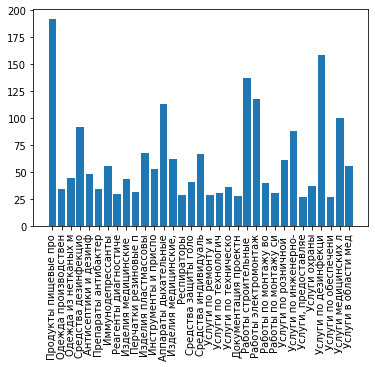

In [20]:
limit = 25
name_length = 20
tmp_df = covid_okpd2_contract_positions[covid_okpd2_contract_positions["count"] > limit]
tmp_df._is_copy = False
tmp_df["okpd2_name"] = tmp_df['okpd2_name'].map(
    lambda name: name[0:name_length if len(name) > name_length else len(name)]
)
plt.bar(tmp_df["okpd2_name"], tmp_df["count"])
plt.xticks(rotation=90)
plt.show()